In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from datetime import datetime, time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import copy
from meteostat import Stations, Daily
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torcheval.metrics import R2Score
import os

In [471]:
# TODO change ecmwf-eps to ecmwf-ens, also ensure there are no other typos

In [79]:
degree_days = 'gw_hdd'

In [80]:
path = "RawData"


def extract_date_time(filename):
    """
    extract the date and time from the filename
    :param filename:
    :return:
    """
    parts = filename.split('.')
    date = parts[1]
    time = parts[2]
    return date, time


def get_date(df, file):
    """get the date from the dataframe and the time from the filename and combine them into a datetime object
    :param df: dataframe containing the date
    :param file: filename containing the time
    :return: datetime object
    """
    #date_str = df[df.iloc[:, 2] == 1].iloc[0]['Date']
    date_str = str(file.split('.')[1])
    time_str = str(file.split('.')[2])
    #date = datetime.strptime(date_str, '%Y-%m-%d')
    date = datetime.strptime(date_str, '%Y%m%d')
    time_value = time(int(time_str), 0)
    combined_datetime = datetime.combine(date.date(), time_value)
    return combined_datetime



ecmwf_files = glob.glob(path + f'/ecmwf.*.[01][02].{degree_days}.csv')
ecmwf_sorted_files = sorted(ecmwf_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[3:]

ecmwf_eps_files = glob.glob(path + f'/ecmwf-eps.*.[01][02].{degree_days}.csv')
ecmwf_eps_sorted_files = sorted(ecmwf_eps_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

gfs_ens_bc_files = glob.glob(path + f'/gfs-ens-bc.*.[01][02].{degree_days}.csv')
gfs_ens_bc_sorted_files = sorted(gfs_ens_bc_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

cmc_ens_files = glob.glob(path + f'/cmc-ens.*.[01][02].{degree_days}.csv')
cmc_ens_sorted_files = sorted(cmc_ens_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]
for _ in range(2):
    set1 = set((extract_date_time(filename) for filename in ecmwf_sorted_files))
    set2 = set((extract_date_time(filename) for filename in ecmwf_eps_sorted_files))

    ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in set2]
    ecmwf_eps_sorted_files = [filename for filename in ecmwf_eps_sorted_files if extract_date_time(filename) in set1]
    cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if extract_date_time(filename) in set1]

    master_set = set((extract_date_time(filename) for filename in cmc_ens_sorted_files))
    gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if
                               extract_date_time(filename) in master_set]

    master_set = set((extract_date_time(filename) for filename in gfs_ens_bc_sorted_files))

    ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in master_set]
    ecmwf_eps_sorted_files = [filename for filename in ecmwf_eps_sorted_files if
                              extract_date_time(filename) in master_set]
    gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if
                               extract_date_time(filename) in master_set]
    cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if extract_date_time(filename) in master_set]

In [213]:
ecmwf_eps_change_df = pd.DataFrame(columns=['ecmwf-eps_9', 'ecmwf-eps_10', 'ecmwf-eps_11', 'ecmwf-eps_12',
                                  'ecmwf-eps_13', 'ecmwf-eps_14'])
passed_rows = []
for i in range(1, len(ecmwf_eps_sorted_files)):
    ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i])
    ecmwf_eps_df = ecmwf_eps_df[ecmwf_eps_df[ecmwf_eps_df.columns[2]] >= 1]
    prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
    prev_ecmwf_eps_df = prev_ecmwf_eps_df[prev_ecmwf_eps_df[prev_ecmwf_eps_df.columns[2]] >= 1]

    date = get_date(ecmwf_eps_df, ecmwf_eps_sorted_files[i])
    prev_date = get_date(prev_ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 == d1:
        offset = 1
    else:
        offset = 0

    changes = []
    try:
        for day in range(8, 14):
            changes.append(ecmwf_eps_df.iloc[day]['Value'] - prev_ecmwf_eps_df.iloc[day + offset]['Value'])
        new_row = pd.DataFrame([changes], columns=ecmwf_eps_change_df.columns, index=[date])
        ecmwf_eps_change_df = pd.concat([ecmwf_eps_change_df, new_row])
    except IndexError:
        print(f"error on {date}")
        passed_rows.append(i)

error on 2020-08-15 12:00:00
error on 2020-08-16 00:00:00
error on 2020-08-16 12:00:00
error on 2020-08-17 00:00:00


In [214]:
i = 1
print(ecmwf_eps_sorted_files[i])
print(ecmwf_eps_sorted_files[i-1])
ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i])
ecmwf_eps_df = ecmwf_eps_df[ecmwf_eps_df[ecmwf_eps_df.columns[2]] >= 1]
prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
prev_ecmwf_eps_df = prev_ecmwf_eps_df[prev_ecmwf_eps_df[prev_ecmwf_eps_df.columns[2]] >= 1]

RawData/ecmwf-eps.20180711.00.gw_hdd.csv
RawData/ecmwf-eps.20180710.12.gw_hdd.csv


In [215]:
display(ecmwf_eps_df)

,Date,Value,Flag (0=obs 1=fcst 2=norm)
7,2018-07-11,0.007,1
8,2018-07-12,0.002,1
9,2018-07-13,0.005,1
10,2018-07-14,0.004,1
11,2018-07-15,0.002,1
12,2018-07-16,0.004,1
13,2018-07-17,0.002,1
14,2018-07-18,0.004,1
15,2018-07-19,0.006,1
16,2018-07-20,0.004,1


In [216]:
display(prev_ecmwf_eps_df)

,Date,Value,Flag (0=obs 1=fcst 2=norm)
8,2018-07-11,0.006,1
9,2018-07-12,0.003,1
10,2018-07-13,0.005,1
11,2018-07-14,0.004,1
12,2018-07-15,0.002,1
13,2018-07-16,0.004,1
14,2018-07-17,0.004,1
15,2018-07-18,0.002,1
16,2018-07-19,0.004,1
17,2018-07-20,0.004,1


In [217]:
display(ecmwf_eps_change_df)

,ecmwf-eps_9,ecmwf-eps_10,ecmwf-eps_11,ecmwf-eps_12,ecmwf-eps_13,ecmwf-eps_14
2018-07-11 00:00:00,0.002,0.000,0.000,0.000,0.001,-0.001
2018-07-11 12:00:00,0.003,0.001,0.000,-0.001,0.000,0.001
2018-07-12 00:00:00,0.000,0.000,0.000,0.001,0.001,-0.001
2018-07-12 12:00:00,0.000,0.000,0.000,0.001,0.001,-0.001
2018-07-13 00:00:00,-0.001,-0.001,-0.001,0.000,0.003,0.003
...,...,...,...,...,...,...
2023-05-15 00:00:00,0.458,0.039,-0.115,-0.153,-0.300,-0.210
2023-05-15 12:00:00,0.478,0.590,0.388,0.165,-0.251,-0.325
2023-05-16 00:00:00,0.015,-0.002,-0.003,-0.011,0.082,0.179
2023-05-16 12:00:00,-0.464,-0.365,-0.078,0.174,0.379,0.271


In [197]:
ecmwf_change_df = pd.DataFrame(columns=['ecmwf_diff_8', 'ecmwf_diff_9',])
passed_rows = []
for i in range(1, len(ecmwf_sorted_files)):
    ecmwf_df = pd.read_csv(ecmwf_sorted_files[i])
    ecmwf_df = ecmwf_df[ecmwf_df[ecmwf_df.columns[2]] >= 1]
    ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
    ecmwf_eps_df = ecmwf_eps_df[ecmwf_eps_df[ecmwf_eps_df.columns[2]] >= 1]

    try:
        ecmwf = ecmwf_df.iloc[8]
        ecmwf_eps = ecmwf_eps_df.iloc[9]
    except IndexError:
        print(f"error on row: {i}")
        passed_rows.append(i)
        continue

    date = get_date(ecmwf_df, ecmwf_sorted_files[i])
    prev_date = get_date(ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]
    if d2 == d1:
        offset = 1
    else:
        offset = 0

    changes = []
    try:
        for day in range(7,9):
            changes.append(ecmwf_df.iloc[day]['Value'] - ecmwf_eps_df.iloc[day + offset]['Value'])
        new_row = pd.DataFrame([changes], columns=ecmwf_change_df.columns, index=[date])
        ecmwf_change_df = pd.concat([ecmwf_change_df, new_row])
    except IndexError:
        print(f"error on {date}")
        passed_rows.append(i)

error on row: 1494
error on row: 1495
error on row: 1496
error on row: 1497


In [202]:
i = 2
print(ecmwf_sorted_files[i])
print(ecmwf_eps_sorted_files[i-1])
ecmwf_df = pd.read_csv(ecmwf_sorted_files[i])
ecmwf_df = ecmwf_df[ecmwf_df[ecmwf_df.columns[2]] >= 1]
ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
ecmwf_eps_df = ecmwf_eps_df[ecmwf_eps_df[ecmwf_eps_df.columns[2]] >= 1]

RawData/ecmwf.20180711.12.gw_hdd.csv
RawData/ecmwf-eps.20180711.00.gw_hdd.csv


In [203]:
ecmwf_df

,Date,Value,Flag (0=obs 1=fcst 2=norm)
8,2018-07-12,0.004,1
9,2018-07-13,0.005,1
10,2018-07-14,0.005,1
11,2018-07-15,0.004,1
12,2018-07-16,0.004,1
13,2018-07-17,0.008,1
14,2018-07-18,0.140,1
15,2018-07-19,0.116,1
16,2018-07-20,0.028,1
17,2018-07-21,0.067,2


In [204]:
ecmwf_eps_df

,Date,Value,Flag (0=obs 1=fcst 2=norm)
7,2018-07-11,0.007,1
8,2018-07-12,0.002,1
9,2018-07-13,0.005,1
10,2018-07-14,0.004,1
11,2018-07-15,0.002,1
12,2018-07-16,0.004,1
13,2018-07-17,0.002,1
14,2018-07-18,0.004,1
15,2018-07-19,0.006,1
16,2018-07-20,0.004,1


In [201]:
display(ecmwf_change_df)

,ecmwf_diff_8,ecmwf_diff_9
2018-07-11 00:00:00,0.131,0.082
2018-07-11 12:00:00,0.110,0.024
2018-07-12 00:00:00,0.016,0.022
2018-07-12 12:00:00,0.011,0.005
2018-07-13 00:00:00,0.009,0.002
...,...,...
2023-05-15 00:00:00,2.305,2.458
2023-05-15 12:00:00,0.062,1.089
2023-05-16 00:00:00,-0.551,1.014
2023-05-16 12:00:00,-0.384,-0.769


In [223]:
gfs_ens_bc_change_df = pd.DataFrame(columns=['gfs-ens-bc_9', 'gfs-ens-bc_10', 'gfs-ens-bc_11', 'gfs-ens-bc_12',
                                  'gfs-ens-bc_13', 'gfs-ens-bc_14'])
passed_rows = []
for i in range(1, len(gfs_ens_bc_sorted_files)):
    gfs_ens_bc_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
    gfs_ens_bc_df = gfs_ens_bc_df[gfs_ens_bc_df[gfs_ens_bc_df.columns[2]] >= 1]
    prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
    prev_ecmwf_eps_df = prev_ecmwf_eps_df[prev_ecmwf_eps_df[prev_ecmwf_eps_df.columns[2]] >= 1]

    try:
        date = get_date(gfs_ens_bc_df, gfs_ens_bc_sorted_files[i])
        prev_date = get_date(prev_ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    except IndexError:
        print(f"error on row: {i}")
        passed_rows.append(i)
        continue

    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]
    if d2 == d1:
        offset = 1
    else:
        offset = 0

    changes = []
    try:
        for day in range(8, 14):
            changes.append(gfs_ens_bc_df.iloc[day]['Value'] - prev_ecmwf_eps_df.iloc[day + offset]['Value'])
        new_row = pd.DataFrame([changes], columns=gfs_ens_bc_change_df.columns, index=[date])
        gfs_ens_bc_change_df = pd.concat([gfs_ens_bc_change_df, new_row])
    except IndexError:
        print(f"error on {date}")
        passed_rows.append(i)

error on 2020-08-15 12:00:00
error on 2020-08-16 00:00:00
error on 2020-08-16 12:00:00
error on 2020-08-17 00:00:00


In [228]:
i = 2
print(gfs_ens_bc_sorted_files[i])
print(ecmwf_eps_sorted_files[i-1])
gfs_ens_bc_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
gfs_ens_bc_df = gfs_ens_bc_df[gfs_ens_bc_df[gfs_ens_bc_df.columns[2]] >= 1]
prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
prev_ecmwf_eps_df = prev_ecmwf_eps_df[prev_ecmwf_eps_df[prev_ecmwf_eps_df.columns[2]] >= 1]

RawData/gfs-ens-bc.20180711.12.gw_hdd.csv
RawData/ecmwf-eps.20180711.00.gw_hdd.csv


In [229]:
display(gfs_ens_bc_df)

,Date,Value,Flag (0=obs 1=fcst 2=norm)
8,2018-07-12,0.006,1
9,2018-07-13,0.006,1
10,2018-07-14,0.004,1
11,2018-07-15,0.007,1
12,2018-07-16,0.012,1
13,2018-07-17,0.020,1
14,2018-07-18,0.017,1
15,2018-07-19,0.011,1
16,2018-07-20,0.007,1
17,2018-07-21,0.005,1


In [230]:
display(prev_ecmwf_eps_df)

,Date,Value,Flag (0=obs 1=fcst 2=norm)
7,2018-07-11,0.007,1
8,2018-07-12,0.002,1
9,2018-07-13,0.005,1
10,2018-07-14,0.004,1
11,2018-07-15,0.002,1
12,2018-07-16,0.004,1
13,2018-07-17,0.002,1
14,2018-07-18,0.004,1
15,2018-07-19,0.006,1
16,2018-07-20,0.004,1


In [231]:
display(gfs_ens_bc_change_df)

,gfs-ens-bc_9,gfs-ens-bc_10,gfs-ens-bc_11,gfs-ens-bc_12,gfs-ens-bc_13,gfs-ens-bc_14
2018-07-11 00:00:00,0.009,0.005,0.002,0.004,0.012,0.012
2018-07-11 12:00:00,0.003,0.002,0.004,0.008,0.012,0.013
2018-07-12 00:00:00,0.004,0.010,0.013,0.011,0.009,0.012
2018-07-12 12:00:00,0.009,0.010,0.009,0.009,0.010,0.008
2018-07-13 00:00:00,0.006,0.009,0.008,0.008,0.008,0.006
...,...,...,...,...,...,...
2023-05-15 00:00:00,0.592,0.056,-0.003,0.069,-0.023,-0.163
2023-05-15 12:00:00,-0.270,0.220,0.588,0.535,0.046,-0.098
2023-05-16 00:00:00,-0.490,-0.434,-0.316,0.016,0.219,0.222
2023-05-16 12:00:00,-0.536,-0.381,-0.049,0.085,0.125,0.201


In [ ]:
cmc_ens_change_df = pd.DataFrame(columns=['cmc-ens_9', 'cmc-ens_10', 'cmc-ens_11', 'cmc-ens_12',
                                  'cmc-ens_13', 'cmc-ens_14'])
passed_rows = []

for i in range(1, len(cmc_ens_sorted_files)):
    cmc_ens_df = pd.read_csv(cmc_ens_sorted_files[i])
    cmc_ens_df = cmc_ens_df[cmc_ens_df[cmc_ens_df.columns[2]] >= 1]
    gfs_ens_bc_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
    gfs_ens_bc_df = gfs_ens_bc_df[gfs_ens_bc_df[gfs_ens_bc_df.columns[2]] >= 1]
    date = get_date(cmc_ens_df, cmc_ens_sorted_files[i])

    changes = []
    try:
        for day in range(8, 14):
            changes.append(cmc_ens_df.iloc[day]['Value'] - gfs_ens_bc_df.iloc[day]['Value'])
        new_row = pd.DataFrame([changes], columns=cmc_ens_change_df.columns, index=[date])
        cmc_ens_change_df = pd.concat([cmc_ens_change_df, new_row])
    except IndexError:
        print(f"error on {date}")
        passed_rows.append(i)

In [ ]:
passed_rows

In [128]:
day_8_error = pd.DataFrame(columns=['day_8_error'])
passed_rows = []

for i in range(1, len(ecmwf_eps_sorted_files)):
    ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i])
    ecmwf_eps_df = ecmwf_eps_df[ecmwf_eps_df[ecmwf_eps_df.columns[2]] >= 1]
    prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
    prev_ecmwf_eps_df = prev_ecmwf_eps_df[prev_ecmwf_eps_df[prev_ecmwf_eps_df.columns[2]] >= 1]

    date = get_date(ecmwf_eps_df, ecmwf_eps_sorted_files[i])
    prev_date = get_date(prev_ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 == d1:
        offset = 1
    else:
        offset = 0
    day = 7
    changes = []
    try:
        changes.append(ecmwf_eps_df.iloc[day]['Value'] - prev_ecmwf_eps_df.iloc[day + offset]['Value'])
        new_row = pd.DataFrame([changes], columns=day_8_error.columns, index=[date])
        day_8_error = pd.concat([day_8_error, new_row])
    except IndexError:
        print(f"error on {date}")
        passed_rows.append(i)

error on 2020-08-15 12:00:00
error on 2020-08-16 00:00:00
error on 2020-08-16 12:00:00
error on 2020-08-17 00:00:00


In [143]:
i = 3
print(ecmwf_eps_sorted_files[i-1])
print(ecmwf_eps_sorted_files[i])
ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i])
ecmwf_eps_df = ecmwf_eps_df[ecmwf_eps_df[ecmwf_eps_df.columns[2]] >= 1]
prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
prev_ecmwf_eps_df = prev_ecmwf_eps_df[prev_ecmwf_eps_df[prev_ecmwf_eps_df.columns[2]] >= 1]

RawData/ecmwf-eps.20180711.12.gw_hdd.csv
RawData/ecmwf-eps.20180712.00.gw_hdd.csv


In [144]:
display(prev_ecmwf_eps_df)

,Date,Value,Flag (0=obs 1=fcst 2=norm)
8,2018-07-12,0.003,1
9,2018-07-13,0.005,1
10,2018-07-14,0.003,1
11,2018-07-15,0.001,1
12,2018-07-16,0.003,1
13,2018-07-17,0.001,1
14,2018-07-18,0.004,1
15,2018-07-19,0.009,1
16,2018-07-20,0.007,1
17,2018-07-21,0.004,1


In [145]:
display(ecmwf_eps_df)

,Date,Value,Flag (0=obs 1=fcst 2=norm)
7,2018-07-12,0.002,1
8,2018-07-13,0.004,1
9,2018-07-14,0.003,1
10,2018-07-15,0.001,1
11,2018-07-16,0.002,1
12,2018-07-17,0.002,1
13,2018-07-18,0.004,1
14,2018-07-19,0.007,1
15,2018-07-20,0.007,1
16,2018-07-21,0.004,1


In [132]:
display(day_8_error)

,day_8_error
2018-07-11 00:00:00,0.002
2018-07-11 12:00:00,0.003
2018-07-12 00:00:00,-0.002
2018-07-12 12:00:00,-0.002
2018-07-13 00:00:00,-0.001
...,...
2023-05-15 00:00:00,0.844
2023-05-15 12:00:00,-0.080
2023-05-16 00:00:00,0.145
2023-05-16 12:00:00,-0.264


In [ ]:
errors_df = pd.DataFrame(columns=['error_9', 'error_10', 'error_11', 'error_12', 'error_13', 'error_14'])
passed_rows = []

for i in range(2, len(ecmwf_eps_sorted_files)):
    ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
    ecmwf_eps_df = ecmwf_eps_df[ecmwf_eps_df[ecmwf_eps_df.columns[2]] >= 1]
    prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-2])
    prev_ecmwf_eps_df = prev_ecmwf_eps_df[prev_ecmwf_eps_df[prev_ecmwf_eps_df.columns[2]] >= 1]

    date = get_date(ecmwf_eps_df, ecmwf_eps_sorted_files[i])
    prev_date = get_date(prev_ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 != d1:
        offset = 1
    else:
        offset = 0

    errors = []
    try:
        for day in range(8, 14):
            errors.append(ecmwf_eps_df.iloc[day - offset]['Value'] - prev_ecmwf_eps_df.iloc[day]['Value'])
        new_row = pd.DataFrame([errors], columns=errors_df.columns, index=[date])
        errors_df = pd.concat([errors_df, new_row])
    except IndexError:
        print(f"error on {date}")
        passed_rows.append(i)

new features

In [ ]:
#add if noon

In [ ]:
errors_df['noon'] = errors_df.index.hour
errors_df['noon'] = errors_df['noon'].apply(lambda x: 1 if x == 12 else 0)

In [ ]:
def f(x):
    y = 1 - (abs(x-7) / 7)
    return y

In [ ]:
errors_df['month'] = errors_df.index.month
#errors_df['month'] = errors_df['month'].apply(lambda x: f(x))

In [ ]:
master_df = pd.concat([gfs_ens_bc_change_df, cmc_ens_change_df, ecmwf_change_df, errors_df,  ecmwf_eps_change_df], axis=1) # removed day_8_error
master_df.fillna(0, inplace=True)
display(master_df[-5:])

In [ ]:
master_df.to_pickle('master_df.pkl')

random forest

In [44]:
master_df = pd.read_pickle('master_df.pkl')

In [ ]:
master_df['ecmwf-eps_9'][-800:].plot()

In [45]:
X = master_df.iloc[:, :-6]
y = master_df.iloc[:, -6:]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=1000, max_depth=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, n_estimators=1000, random_state=42)

In [47]:
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 1.0294975013128134


RNN

In [300]:
input_features = master_df.iloc[:, :-6].values ** 2
target_variables = master_df.iloc[:, -6:].values

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    input_features, target_variables, test_size=0.2, shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False)

# Scale the input features based on the training data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Scale the validation and test data based on the training data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data to PyTorch tensors

X_train_tensor = torch.Tensor(X_train_scaled)
y_train_tensor = torch.Tensor(y_train)
X_val_tensor = torch.Tensor(X_val_scaled)
y_val_tensor = torch.Tensor(y_val)
X_test_tensor = torch.Tensor(X_test_scaled)
y_test_tensor = torch.Tensor(y_test)

In [303]:
#benchmark error
total_mse = 0
c = 0
for i in range(1, len(y_test_tensor)):
    #mse = mean_squared_error(y_test_tensor[i], y_test_tensor[i-1])
    mse = mean_squared_error(y_test_tensor[i], [0,0,0,0,0,0])
    total_mse += mse
    c += 1

total_mse/c

0.09123534930199231

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 64)  # Dense layer with 64 units
        self.fc2 = nn.Linear(64, output_size)  # Final output layer

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = F.relu(out)  # Apply ReLU activation between LSTM and first dense layer
        out = self.fc1(out[:, -1, :])
        out = F.relu(out)  # Apply ReLU activation to the output of the first dense layer
        out = self.fc2(out)

        return out

In [ ]:
input_size = X_train_tensor.shape[1]
output_size = y_train_tensor.shape[1]
hidden_size = 256
num_layers = 3
dropout = 0.3
lr = 0.01
mps_device = torch.device("mps")

In [ ]:
model = RNN(input_size, hidden_size, output_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)

In [ ]:
num_epochs = 100
sequence_length = 10  # Number of previous days to consider

best_loss = float('inf')
best_model = None
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    # Loop through each sequence in the training data
    for i in range(sequence_length, X_train_tensor.shape[0]):
        # Extract the current sequence and target
        input_seq = X_train_tensor[i - sequence_length:i].view(1, sequence_length, -1)
        target_seq = y_train_tensor[i]

        # Forward pass
        output = model(input_seq)
        loss = criterion(output, target_seq.unsqueeze(0))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / (X_train_tensor.shape[0] - sequence_length)
    train_losses.append(average_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_loss}')

    # Validation stage
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_val_loss = 0

        for i in range(sequence_length, X_val_tensor.shape[0]):
            input_seq = X_val_tensor[i - sequence_length:i].view(1, sequence_length, -1)
            target_seq = y_val_tensor[i]

            output = model(input_seq)
            val_loss = criterion(output, target_seq.unsqueeze(0))

            total_val_loss += val_loss.item()

        average_val_loss = total_val_loss / (X_val_tensor.shape[0] - sequence_length)
        val_losses.append(average_val_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {average_val_loss}')

        # Check if current model is the best based on validation loss
        if average_val_loss < best_loss:
            best_loss = average_val_loss
            best_model = copy.deepcopy(model)

# After training, use the best model for testing
model = best_model

In [ ]:
def plot_losses(train_losses, val_losses):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(train_losses, label='Training Loss')
    ax.plot(val_losses, label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()
plot_losses(train_losses, val_losses)

In [ ]:
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    test_loss = 0.0
    predictions = []

    for i in range(sequence_length, X_test_tensor.shape[0]):
        input_seq = X_test_tensor[i - sequence_length:i].view(1, sequence_length, -1)
        target_seq = y_test_tensor[i]

        output = model(input_seq)
        loss = criterion(output, target_seq.unsqueeze(0))

        test_loss += loss.item()

        # Extract the scalar value from the tensor and append it to predictions
        predictions.append(output.squeeze().tolist())

    average_test_loss = test_loss / (X_test_tensor.shape[0] - sequence_length)
    print(f'Test Loss: {average_test_loss}')

    # Convert the predictions and target values to numpy arrays
    predictions = np.array(predictions)
    targets = y_test_tensor[sequence_length:].numpy()

    # Evaluate the performance using appropriate metrics
    # For example, calculate mean squared error (MSE)
    mse = mean_squared_error(targets, predictions)
    metric = R2Score()
    r2 = metric.update(torch.tensor(predictions), torch.tensor(targets)).compute()
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'R2 Score: {r2}')

In [ ]:
def prediction(input):
    model.eval()

    with torch.no_grad():
        input_seq = torch.tensor(input).view(1, sequence_length, -1)
        output = model(input_seq)
        return output.squeeze().tolist()

In [ ]:
pred = prediction(X_test_tensor[-sequence_length:])

In [ ]:
pred

In [ ]:
y_test_tensor[-1]

In [ ]:
if not os.path.exists('master_df.pkl'):
    print('does not exist')
else:
    print('exists')

# Autogloun

In [2]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common.utils.utils import setup_outputdir
from autogluon.core.utils.loaders import load_pkl
from autogluon.core.utils.savers import save_pkl
from autogluon.features.generators import AutoMLPipelineFeatureGenerator
import os.path

In [3]:
imp_features = list(set(["day_8_error", "gfs-ens-bc_9", "ecmwf_diff_8", "noon", "cmc-ens_9",
                    "gfs-ens-bc_10", "gfs-ens-bc_9", "ecmwf_diff_9", "cmc-ens_10",
                    "noon", "gfs-ens-bc_10", "gfs-ens-bc_11", "gfs-ens-bc_9",
                    "cmc-ens_11", "gfs-ens-bc_11", "gfs-ens-bc_12", "gfs-ens-bc_10",
                    "gfs-ens-bc_12", "gfs-ens-bc_13"]))

In [4]:
labels = ['ecmwf-eps_9', 'ecmwf-eps_10', 'ecmwf-eps_11', 'ecmwf-eps_12', 'ecmwf-eps_13',
          'ecmwf-eps_14']

In [5]:
#y = master_df.iloc[:, -6:].copy()
#y = y.reset_index(drop=True)
#X = master_df.iloc[:, :-6].copy()
#X['Date'] = X.index
#X = X.reset_index(drop=True)

In [6]:
#auto_ml_pipeline_feature_generator = AutoMLPipelineFeatureGenerator()
#X = auto_ml_pipeline_feature_generator.fit_transform(X=X)

In [7]:
#df = pd.concat([X, y], axis=1)

In [8]:
degree_days = 'gw_hdd'

In [9]:
master_df = pd.read_pickle(f'master_df_{degree_days}.pkl')

In [11]:
display(master_df)

,gfs-ens-bc_9,gfs-ens-bc_10,gfs-ens-bc_11,gfs-ens-bc_12,gfs-ens-bc_13,gfs-ens-bc_14,cmc-ens_9,cmc-ens_10,cmc-ens_11,cmc-ens_12,...,error_12,error_13,error_14,noon,ecmwf-eps_9,ecmwf-eps_10,ecmwf-eps_11,ecmwf-eps_12,ecmwf-eps_13,ecmwf-eps_14
2018-07-11 00:00:00,0.009,0.005,0.002,0.004,0.012,0.012,-0.008,-0.005,-0.001,-0.003,...,0.000,0.000,0.000,0.0,0.002,0.000,0.000,0.000,0.001,-0.001
2018-07-11 12:00:00,0.003,0.002,0.004,0.008,0.012,0.013,-0.003,-0.002,-0.004,-0.008,...,0.000,0.001,-0.001,1.0,0.003,0.001,0.000,-0.001,0.000,0.001
2018-07-12 00:00:00,0.004,0.010,0.013,0.011,0.009,0.012,-0.007,-0.011,-0.013,-0.011,...,0.000,-0.001,0.000,0.0,0.000,0.000,0.000,0.001,0.001,-0.001
2018-07-12 12:00:00,0.009,0.010,0.009,0.009,0.010,0.008,-0.008,-0.009,-0.009,-0.010,...,0.001,0.001,-0.001,1.0,0.000,0.000,0.000,0.001,0.001,-0.001
2018-07-13 00:00:00,0.006,0.009,0.008,0.008,0.008,0.006,-0.007,-0.009,-0.009,-0.010,...,0.000,0.001,0.001,0.0,-0.001,-0.001,-0.001,0.000,0.003,0.003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15 00:00:00,0.592,0.056,-0.003,0.069,-0.023,-0.163,-0.752,-0.071,-0.003,0.156,...,0.004,-0.137,-0.039,0.0,0.458,0.039,-0.115,-0.153,-0.300,-0.210
2023-05-15 12:00:00,-0.270,0.220,0.588,0.535,0.046,-0.098,-0.139,-0.626,-0.916,-0.714,...,-0.153,-0.300,-0.210,1.0,0.478,0.590,0.388,0.165,-0.251,-0.325
2023-05-16 00:00:00,-0.490,-0.434,-0.316,0.016,0.219,0.222,0.330,-0.207,-0.039,0.085,...,0.388,0.165,-0.251,0.0,0.015,-0.002,-0.003,-0.011,0.082,0.179
2023-05-16 12:00:00,-0.536,-0.381,-0.049,0.085,0.125,0.201,-0.360,-0.185,-0.309,-0.252,...,-0.011,0.082,0.179,1.0,-0.464,-0.365,-0.078,0.174,0.379,0.271


In [12]:
train_len = 0.8
train_data = TabularDataset(master_df[:int(len(master_df)*train_len)])
test_data = TabularDataset(master_df[int(len(master_df)*train_len):])

In [13]:
test_data

,gfs-ens-bc_9,gfs-ens-bc_10,gfs-ens-bc_11,gfs-ens-bc_12,gfs-ens-bc_13,gfs-ens-bc_14,cmc-ens_9,cmc-ens_10,cmc-ens_11,cmc-ens_12,...,error_12,error_13,error_14,noon,ecmwf-eps_9,ecmwf-eps_10,ecmwf-eps_11,ecmwf-eps_12,ecmwf-eps_13,ecmwf-eps_14
2022-06-03 00:00:00,-0.311,-0.296,-0.325,-0.113,0.131,0.249,0.272,0.178,0.121,0.060,...,0.016,-0.049,-0.072,0.0,-0.128,-0.068,0.026,0.021,0.002,0.007
2022-06-03 12:00:00,-0.258,-0.146,-0.059,0.019,0.062,0.040,-0.070,-0.170,-0.144,-0.096,...,0.021,0.002,0.007,1.0,-0.042,-0.085,-0.028,0.021,0.030,-0.026
2022-06-04 00:00:00,-0.238,-0.130,0.000,0.035,0.035,0.089,0.201,-0.113,-0.270,-0.269,...,-0.028,0.021,0.030,0.0,0.032,0.000,0.036,0.072,0.047,0.033
2022-06-04 12:00:00,-0.057,0.026,-0.024,-0.064,-0.061,0.033,-0.119,-0.236,-0.202,-0.056,...,0.072,0.047,0.033,1.0,-0.179,-0.218,-0.228,-0.159,-0.049,-0.004
2022-06-05 00:00:00,0.153,0.310,0.418,0.257,0.019,-0.017,-0.160,-0.389,-0.462,-0.334,...,-0.228,-0.159,-0.049,0.0,0.134,0.040,0.018,0.068,0.058,0.087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15 00:00:00,0.592,0.056,-0.003,0.069,-0.023,-0.163,-0.752,-0.071,-0.003,0.156,...,0.004,-0.137,-0.039,0.0,0.458,0.039,-0.115,-0.153,-0.300,-0.210
2023-05-15 12:00:00,-0.270,0.220,0.588,0.535,0.046,-0.098,-0.139,-0.626,-0.916,-0.714,...,-0.153,-0.300,-0.210,1.0,0.478,0.590,0.388,0.165,-0.251,-0.325
2023-05-16 00:00:00,-0.490,-0.434,-0.316,0.016,0.219,0.222,0.330,-0.207,-0.039,0.085,...,0.388,0.165,-0.251,0.0,0.015,-0.002,-0.003,-0.011,0.082,0.179
2023-05-16 12:00:00,-0.536,-0.381,-0.049,0.085,0.125,0.201,-0.360,-0.185,-0.309,-0.252,...,-0.011,0.082,0.179,1.0,-0.464,-0.365,-0.078,0.174,0.379,0.271


In [14]:
#train_data = train_data.loc[:, imp_features + labels]
#test_data = test_data.loc[:, imp_features + labels]

In [15]:
save_path = 'models'

In [17]:
class MultilabelPredictor():
    """ Tabular Predictor for predicting multiple columns in table.
        Creates multiple TabularPredictor objects which you can also use individually.
        You can access the TabularPredictor for a particular label via: `multilabel_predictor.get_predictor(label_i)`

        Parameters
        ----------
        labels : List[str]
            The ith element of this list is the column (i.e. `label`) predicted by the ith TabularPredictor stored in this object.
        path : str, default = None
            Path to directory where models and intermediate outputs should be saved.
            If unspecified, a time-stamped folder called "AutogluonModels/ag-[TIMESTAMP]" will be created in the working directory to store all models.
            Note: To call `fit()` twice and save all results of each fit, you must specify different `path` locations or don't specify `path` at all.
            Otherwise files from first `fit()` will be overwritten by second `fit()`.
            Caution: when predicting many labels, this directory may grow large as it needs to store many TabularPredictors.
        problem_types : List[str], default = None
            The ith element is the `problem_type` for the ith TabularPredictor stored in this object.
        eval_metrics : List[str], default = None
            The ith element is the `eval_metric` for the ith TabularPredictor stored in this object.
        consider_labels_correlation : bool, default = True
            Whether the predictions of multiple labels should account for label correlations or predict each label independently of the others.
            If True, the ordering of `labels` may affect resulting accuracy as each label is predicted conditional on the previous labels appearing earlier in this list (i.e. in an auto-regressive fashion).
            Set to False if during inference you may want to individually use just the ith TabularPredictor without predicting all the other labels.
        kwargs :
            Arguments passed into the initialization of each TabularPredictor.

    """

    multi_predictor_file = 'multilabel_predictor.pkl'

    def __init__(self, labels, path=None, problem_types=None, eval_metrics=None, consider_labels_correlation=True, **kwargs):
        if len(labels) < 2:
            raise ValueError("MultilabelPredictor is only intended for predicting MULTIPLE labels (columns), use TabularPredictor for predicting one label (column).")
        if (problem_types is not None) and (len(problem_types) != len(labels)):
            raise ValueError("If provided, `problem_types` must have same length as `labels`")
        if (eval_metrics is not None) and (len(eval_metrics) != len(labels)):
            raise ValueError("If provided, `eval_metrics` must have same length as `labels`")
        self.path = setup_outputdir(path, warn_if_exist=False)
        self.labels = labels
        self.consider_labels_correlation = consider_labels_correlation
        self.predictors = {}  # key = label, value = TabularPredictor or str path to the TabularPredictor for this label
        if eval_metrics is None:
            self.eval_metrics = {}
        else:
            self.eval_metrics = {labels[i] : eval_metrics[i] for i in range(len(labels))}
        problem_type = None
        eval_metric = None
        for i in range(len(labels)):
            label = labels[i]
            path_i = self.path + "Predictor_" + label
            if problem_types is not None:
                problem_type = problem_types[i]
            if eval_metrics is not None:
                eval_metric = eval_metrics[i]
            self.predictors[label] = TabularPredictor(label=label, problem_type=problem_type, eval_metric=eval_metric, path=path_i, **kwargs)

    def fit(self, train_data, tuning_data=None, **kwargs):
        """ Fits a separate TabularPredictor to predict each of the labels.

            Parameters
            ----------
            train_data, tuning_data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                See documentation for `TabularPredictor.fit()`.
            kwargs :
                Arguments passed into the `fit()` call for each TabularPredictor.
        """
        if isinstance(train_data, str):
            train_data = TabularDataset(train_data)
        if tuning_data is not None and isinstance(tuning_data, str):
            tuning_data = TabularDataset(tuning_data)
        train_data_og = train_data.copy()
        if tuning_data is not None:
            tuning_data_og = tuning_data.copy()
        else:
            tuning_data_og = None
        save_metrics = len(self.eval_metrics) == 0
        for i in range(len(self.labels)):
            label = self.labels[i]
            predictor = self.get_predictor(label)
            if not self.consider_labels_correlation:
                labels_to_drop = [l for l in self.labels if l != label]
            else:
                labels_to_drop = [self.labels[j] for j in range(i+1, len(self.labels))]
            train_data = train_data_og.drop(labels_to_drop, axis=1)
            if tuning_data is not None:
                tuning_data = tuning_data_og.drop(labels_to_drop, axis=1)
            print(f"Fitting TabularPredictor for label: {label} ...")
            predictor.fit(train_data=train_data, tuning_data=tuning_data, **kwargs)
            self.predictors[label] = predictor.path
            if save_metrics:
                self.eval_metrics[label] = predictor.eval_metric
        self.save()

    def predict(self, data, **kwargs):
        """ Returns DataFrame with label columns containing predictions for each label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. If label columns are present in this data, they will be ignored. See documentation for `TabularPredictor.predict()`.
            kwargs :
                Arguments passed into the predict() call for each TabularPredictor.
        """
        return self._predict(data, as_proba=False, **kwargs)

    def predict_proba(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `predict_proba()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. See documentation for `TabularPredictor.predict()` and `TabularPredictor.predict_proba()`.
            kwargs :
                Arguments passed into the `predict_proba()` call for each TabularPredictor (also passed into a `predict()` call).
        """
        return self._predict(data, as_proba=True, **kwargs)

    def evaluate(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `evaluate()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to evalate predictions of all labels for, must contain all labels as columns. See documentation for `TabularPredictor.evaluate()`.
            kwargs :
                Arguments passed into the `evaluate()` call for each TabularPredictor (also passed into the `predict()` call).
        """
        data = self._get_data(data)
        eval_dict = {}
        for label in self.labels:
            print(f"Evaluating TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            eval_dict[label] = predictor.evaluate(data, **kwargs)
            if self.consider_labels_correlation:
                data[label] = predictor.predict(data, **kwargs)
        return eval_dict

    def feature_imp(self,data, **kwargs):
        data = self._get_data(data)
        eval_dict = {}
        for label in self.labels:
            predictor = self.get_predictor(label)
            eval_dict[label] = predictor.feature_importance(data, **kwargs)
            print(f"Evaluating feature importance for label: {label} ...")
        return eval_dict

    def best_model(self):
        for label in self.labels:
            predictor = self.get_predictor(label)
            best_model = predictor.best_model()
            print(f"Best model for {label}: {best_model}")

    def save(self):
        """ Save MultilabelPredictor to disk. """
        for label in self.labels:
            if not isinstance(self.predictors[label], str):
                self.predictors[label] = self.predictors[label].path
        save_pkl.save(path=self.path+self.multi_predictor_file, object=self)
        print(f"MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('{self.path}')")

    @classmethod
    def load(cls, path):
        """ Load MultilabelPredictor from disk `path` previously specified when creating this MultilabelPredictor. """
        path = os.path.expanduser(path)
        if path[-1] != os.path.sep:
            path = path + os.path.sep
        return load_pkl.load(path=path+cls.multi_predictor_file)

    def get_predictor(self, label):
        """ Returns TabularPredictor which is used to predict this label. """
        predictor = self.predictors[label]
        if isinstance(predictor, str):
            return TabularPredictor.load(path=predictor)
        return predictor

    def _get_data(self, data):
        if isinstance(data, str):
            return TabularDataset(data)
        return data.copy()

    def _predict(self, data, as_proba=False, **kwargs):
        data = self._get_data(data)
        if as_proba:
            predproba_dict = {}
        for label in self.labels:
            print(f"Predicting with TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            if as_proba:
                predproba_dict[label] = predictor.predict_proba(data, as_multiclass=True, **kwargs)
            data[label] = predictor.predict(data, **kwargs)
        if not as_proba:
            return data[self.labels]
        else:
            return predproba_dict

In [ ]:
multi_predictor = MultilabelPredictor(labels=labels, path=save_path)

In [ ]:
multi_predictor.fit(train_data) # add presets='best_quality' for better results, but longer runtime

In [45]:
multi_predictor = MultilabelPredictor.load(f"models/{degree_days}")
test_data_nolab = test_data.drop(columns=labels)
test_data_nolab.head()

,gfs-ens-bc_9,gfs-ens-bc_10,gfs-ens-bc_11,gfs-ens-bc_12,gfs-ens-bc_13,gfs-ens-bc_14,cmc-ens_9,cmc-ens_10,cmc-ens_11,cmc-ens_12,...,ecmwf_diff_8,ecmwf_diff_9,day_8_error,error_9,error_10,error_11,error_12,error_13,error_14,noon
2022-06-03 00:00:00,-0.311,-0.296,-0.325,-0.113,0.131,0.249,0.272,0.178,0.121,0.060,...,-0.302,-0.473,0.017,-0.122,0.004,0.088,0.016,-0.049,-0.072,0.0
2022-06-03 12:00:00,-0.258,-0.146,-0.059,0.019,0.062,0.040,-0.070,-0.170,-0.144,-0.096,...,-0.450,-0.458,-0.064,-0.128,-0.068,0.026,0.021,0.002,0.007,1.0
2022-06-04 00:00:00,-0.238,-0.130,0.000,0.035,0.035,0.089,0.201,-0.113,-0.270,-0.269,...,-0.147,-0.091,0.081,-0.064,-0.042,-0.085,-0.028,0.021,0.030,0.0
2022-06-04 12:00:00,-0.057,0.026,-0.024,-0.064,-0.061,0.033,-0.119,-0.236,-0.202,-0.056,...,-0.211,-0.387,-0.189,0.032,0.000,0.036,0.072,0.047,0.033,1.0
2022-06-05 00:00:00,0.153,0.310,0.418,0.257,0.019,-0.017,-0.160,-0.389,-0.462,-0.334,...,-0.146,-0.114,0.230,-0.189,-0.179,-0.218,-0.228,-0.159,-0.049,0.0


In [46]:
#feature_imp = multi_predictor.feature_imp(train_data)

In [47]:
predictions = multi_predictor.predict(test_data_nolab)
print("Predictions:  \n", predictions)

Predicting with TabularPredictor for label: ecmwf-eps_9 ...
Predicting with TabularPredictor for label: ecmwf-eps_10 ...
Predicting with TabularPredictor for label: ecmwf-eps_11 ...
Predicting with TabularPredictor for label: ecmwf-eps_12 ...
Predicting with TabularPredictor for label: ecmwf-eps_13 ...
Predicting with TabularPredictor for label: ecmwf-eps_14 ...
Predictions:  
                      ecmwf-eps_9  ecmwf-eps_10  ecmwf-eps_11  ecmwf-eps_12  \
2022-06-03 00:00:00    -0.047812     -0.084168     -0.034573      0.040345   
2022-06-03 12:00:00    -0.067423     -0.061415     -0.025522      0.008862   
2022-06-04 00:00:00     0.022963     -0.005437     -0.001151      0.013671   
2022-06-04 12:00:00    -0.126277     -0.073251     -0.036737     -0.017115   
2022-06-05 00:00:00     0.120245      0.062511      0.066605      0.042480   
...                          ...           ...           ...           ...   
2023-05-15 00:00:00     0.729574      0.480662      0.330412      0.24921

In [48]:
preds_df = pd.DataFrame(predictions)

In [49]:
preds_df = preds_df.sum(axis=1)

In [50]:
display(preds_df)

2022-06-03 00:00:00    0.060900
2022-06-03 12:00:00   -0.118428
2022-06-04 00:00:00    0.101052
2022-06-04 12:00:00   -0.221299
2022-06-05 00:00:00    0.328615
                         ...   
2023-05-15 00:00:00    2.044572
2023-05-15 12:00:00    0.439371
2023-05-16 00:00:00    1.527016
2023-05-16 12:00:00   -0.512902
2023-05-17 00:00:00   -0.158679
Length: 697, dtype: float32

In [44]:
preds_df.to_pickle("predictions.pkl")

In [36]:
display(predictions.iloc[-4].sum())

0.43937117

In [35]:
display(test_data[labels].iloc[-4].sum())

1.0449999999999995

In [462]:
evaluations = multi_predictor.evaluate(test_data)
#print(evaluations)
print("Evaluated using metrics:", multi_predictor.eval_metrics)

Evaluating TabularPredictor for label: ecmwf-eps_9 ...


Evaluation: root_mean_squared_error on test data: -0.44978843997913576
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.44978843997913576,
    "mean_squared_error": -0.2023096407388646,
    "mean_absolute_error": -0.2931654674506631,
    "r2": 0.7135151243631976,
    "pearsonr": 0.8449957007541864,
    "median_absolute_error": -0.17510813072323828
}


Evaluating TabularPredictor for label: ecmwf-eps_10 ...


Evaluation: root_mean_squared_error on test data: -0.6764796014978284
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.6764796014978284,
    "mean_squared_error": -0.45762465124266066,
    "mean_absolute_error": -0.4420161696425479,
    "r2": 0.3704471394740121,
    "pearsonr": 0.6088384278246148,
    "median_absolute_error": -0.25709498697519306
}


Evaluating TabularPredictor for label: ecmwf-eps_11 ...


Evaluation: root_mean_squared_error on test data: -0.7607432298036907
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.7607432298036907,
    "mean_squared_error": -0.578730261692151,
    "mean_absolute_error": -0.5119904895520613,
    "r2": 0.13895968873137565,
    "pearsonr": 0.3929303620593549,
    "median_absolute_error": -0.33339778470993053
}


Evaluating TabularPredictor for label: ecmwf-eps_12 ...


Evaluation: root_mean_squared_error on test data: -0.8066477296445551
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.8066477296445551,
    "mean_squared_error": -0.6506805597407153,
    "mean_absolute_error": -0.5331466025252021,
    "r2": 0.06311776616208198,
    "pearsonr": 0.31275983971403176,
    "median_absolute_error": -0.3152267552614223
}


Evaluating TabularPredictor for label: ecmwf-eps_13 ...


Evaluation: root_mean_squared_error on test data: -0.7993791220276688
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.7993791220276688,
    "mean_squared_error": -0.6390069807337266,
    "mean_absolute_error": -0.5260176867481682,
    "r2": 0.034432424683261464,
    "pearsonr": 0.284838407288626,
    "median_absolute_error": -0.3217272799015021
}


Evaluating TabularPredictor for label: ecmwf-eps_14 ...


Evaluation: root_mean_squared_error on test data: -0.7892413410962222
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.7892413410962222,
    "mean_squared_error": -0.6229018944953635,
    "mean_absolute_error": -0.5282344038051899,
    "r2": 0.11105426002895313,
    "pearsonr": 0.365085831354515,
    "median_absolute_error": -0.3413858379721635
}


Evaluated using metrics: {'ecmwf-eps_9': root_mean_squared_error, 'ecmwf-eps_10': root_mean_squared_error, 'ecmwf-eps_11': root_mean_squared_error, 'ecmwf-eps_12': root_mean_squared_error, 'ecmwf-eps_13': root_mean_squared_error, 'ecmwf-eps_14': root_mean_squared_error}


In [463]:
evaluations

{'ecmwf-eps_9': {'root_mean_squared_error': -0.44978843997913576,
  'mean_squared_error': -0.2023096407388646,
  'mean_absolute_error': -0.2931654674506631,
  'r2': 0.7135151243631976,
  'pearsonr': 0.8449957007541864,
  'median_absolute_error': -0.17510813072323828},
 'ecmwf-eps_10': {'root_mean_squared_error': -0.6764796014978284,
  'mean_squared_error': -0.45762465124266066,
  'mean_absolute_error': -0.4420161696425479,
  'r2': 0.3704471394740121,
  'pearsonr': 0.6088384278246148,
  'median_absolute_error': -0.25709498697519306},
 'ecmwf-eps_11': {'root_mean_squared_error': -0.7607432298036907,
  'mean_squared_error': -0.578730261692151,
  'mean_absolute_error': -0.5119904895520613,
  'r2': 0.13895968873137565,
  'pearsonr': 0.3929303620593549,
  'median_absolute_error': -0.33339778470993053},
 'ecmwf-eps_12': {'root_mean_squared_error': -0.8066477296445551,
  'mean_squared_error': -0.6506805597407153,
  'mean_absolute_error': -0.5331466025252021,
  'r2': 0.06311776616208198,
  'pea

In [249]:
predictor_class = multi_predictor.get_predictor('ecmwf-eps_9')
display(predictor_class.leaderboard(silent=True))

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.468409,0.231013,58.711627,0.000291,0.133353,2,True,9
1,WeightedEnsemble_L3,-0.475032,0.536557,101.832554,0.000277,0.110878,3,True,16
2,NeuralNetTorch_BAG_L1,-0.475452,0.027153,25.566166,0.027153,25.566166,1,True,8
3,NeuralNetTorch_BAG_L2,-0.476476,0.473207,81.249239,0.028834,22.037152,2,True,15
4,CatBoost_BAG_L2,-0.483327,0.457172,65.527294,0.012799,6.315207,2,True,11
5,NeuralNetFastAI_BAG_L1,-0.486086,0.048311,14.295182,0.048311,14.295182,1,True,6
6,ExtraTreesMSE_BAG_L2,-0.488580,0.569718,59.917265,0.125345,0.705177,2,True,12
7,NeuralNetFastAI_BAG_L2,-0.493348,0.494648,73.369318,0.050275,14.157231,2,True,13
8,RandomForestMSE_BAG_L2,-0.493732,0.566341,63.005658,0.121968,3.793570,2,True,10
9,CatBoost_BAG_L1,-0.494100,0.012024,8.361173,0.012024,8.361173,1,True,4


In [250]:
predictor_class.get_model_best()

'WeightedEnsemble_L2'

In [251]:
display(test_data)

,gfs-ens-bc_9,gfs-ens-bc_10,gfs-ens-bc_11,gfs-ens-bc_12,gfs-ens-bc_13,gfs-ens-bc_14,cmc-ens_9,cmc-ens_10,cmc-ens_11,cmc-ens_12,...,error_12,error_13,error_14,noon,ecmwf-eps_9,ecmwf-eps_10,ecmwf-eps_11,ecmwf-eps_12,ecmwf-eps_13,ecmwf-eps_14
2022-06-03 00:00:00,-0.311,-0.296,-0.325,-0.113,0.131,0.249,0.272,0.178,0.121,0.060,...,0.016,-0.049,-0.072,0.0,-0.128,-0.068,0.026,0.021,0.002,0.007
2022-06-03 12:00:00,-0.258,-0.146,-0.059,0.019,0.062,0.040,-0.070,-0.170,-0.144,-0.096,...,0.021,0.002,0.007,1.0,-0.042,-0.085,-0.028,0.021,0.030,-0.026
2022-06-04 00:00:00,-0.238,-0.130,0.000,0.035,0.035,0.089,0.201,-0.113,-0.270,-0.269,...,-0.028,0.021,0.030,0.0,0.032,0.000,0.036,0.072,0.047,0.033
2022-06-04 12:00:00,-0.057,0.026,-0.024,-0.064,-0.061,0.033,-0.119,-0.236,-0.202,-0.056,...,0.072,0.047,0.033,1.0,-0.179,-0.218,-0.228,-0.159,-0.049,-0.004
2022-06-05 00:00:00,0.153,0.310,0.418,0.257,0.019,-0.017,-0.160,-0.389,-0.462,-0.334,...,-0.228,-0.159,-0.049,0.0,0.134,0.040,0.018,0.068,0.058,0.087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15 00:00:00,0.592,0.056,-0.003,0.069,-0.023,-0.163,-0.752,-0.071,-0.003,0.156,...,0.004,-0.137,-0.039,0.0,0.458,0.039,-0.115,-0.153,-0.300,-0.210
2023-05-15 12:00:00,-0.270,0.220,0.588,0.535,0.046,-0.098,-0.139,-0.626,-0.916,-0.714,...,-0.153,-0.300,-0.210,1.0,0.478,0.590,0.388,0.165,-0.251,-0.325
2023-05-16 00:00:00,-0.490,-0.434,-0.316,0.016,0.219,0.222,0.330,-0.207,-0.039,0.085,...,0.388,0.165,-0.251,0.0,0.015,-0.002,-0.003,-0.011,0.082,0.179
2023-05-16 12:00:00,-0.536,-0.381,-0.049,0.085,0.125,0.201,-0.360,-0.185,-0.309,-0.252,...,-0.011,0.082,0.179,1.0,-0.464,-0.365,-0.078,0.174,0.379,0.271


# feature importance / training models for individual days

In [ ]:
from collections import Counter

In [ ]:
most_important = []

for i in range(0, 5):
    day = i
    train_df = train_data.iloc[:, :-5+day]
    test_df = test_data.iloc[:, :-5+day]
    #display(train_df.head())
    label = f"ecmwf-eps_{day+9}"
    predictor = TabularPredictor(label=label).fit(train_df)
    y_test = test_df[label]
    test_data_nolab = test_df.drop(columns=[label])
    print(f"results for {label}")
    y_pred = predictor.predict(test_data_nolab)
    perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    shap_values = predictor.feature_importance(test_df)
    display(shap_values)
    most_important.append(list(shap_values.index[:6].values))

In [ ]:
item_counts = Counter([item for sublist in most_important for item in sublist])
important_features = []
for item, count in item_counts.items():
    print(f'{item}: {count}')
    important_features.append(item)

In [252]:
import autogluon.eda.auto as auto

In [257]:
day = 2
train_df = train_data.iloc[:, :-5+day]
test_df = test_data.iloc[:, :-5+day]
#display(train_df.head())
label = f"ecmwf-eps_{day+9}"

No path specified. Models will be saved in: "AutogluonModels/ag-20230614_180758/"


### Model Prediction for ecmwf-eps_11

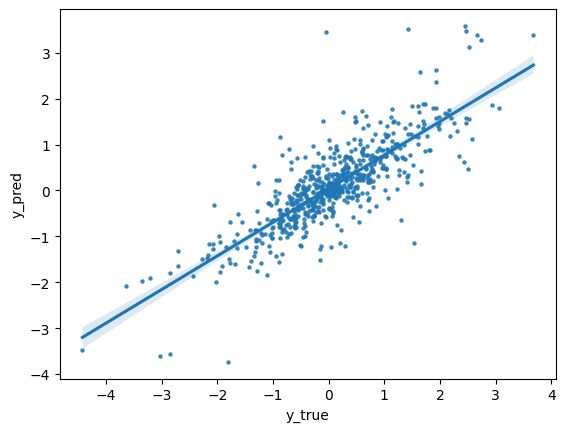

### Model Leaderboard

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestMSE,-0.523167,-0.470649,0.038917,0.025066,1.467219,0.038917,0.025066,1.467219,1,True,1


### Feature Importance for Trained Model

,importance,stddev,p_value,n,p99_high,p99_low
ecmwf-eps_10,0.846595,0.031876,2.407174e-07,5,0.912227,0.780962
ecmwf-eps_9,0.116389,0.007098,1.651268e-06,5,0.131003,0.101775
gfs-ens-bc_12,0.009765,0.001645,9.304208e-05,5,0.013151,0.006378
cmc-ens_11,0.002665,0.000729,6.096656e-04,5,0.004167,0.001164
error_10,0.002272,0.000357,7.084295e-05,5,0.003007,0.001537
gfs-ens-bc_9,0.001937,0.000567,7.868675e-04,5,0.003104,0.000770
gfs-ens-bc_13,0.001627,0.000574,1.587372e-03,5,0.002809,0.000445
cmc-ens_10,0.001625,0.001067,1.356085e-02,5,0.003822,-0.000571
error_9,0.001257,0.000338,5.729623e-04,5,0.001954,0.000561
gfs-ens-bc_14,0.000521,0.000790,1.073785e-01,5,0.002148,-0.001107


### Rows with the highest prediction error

Rows in this category worth inspecting for the causes of the error

,gfs-ens-bc_9,gfs-ens-bc_10,gfs-ens-bc_11,gfs-ens-bc_12,gfs-ens-bc_13,gfs-ens-bc_14,cmc-ens_9,cmc-ens_10,cmc-ens_11,cmc-ens_12,...,error_11,error_12,error_13,error_14,noon,ecmwf-eps_9,ecmwf-eps_10,ecmwf-eps_11,ecmwf-eps_11_pred,error
2022-02-16 00:00:00,-1.123,0.861,-0.974,-2.792,-2.362,-1.960,2.454,1.494,1.198,0.869,...,-0.625,1.534,3.628,3.250,0.0,4.604,3.334,-0.040,3.448257,3.488257
2022-02-15 12:00:00,-4.859,-2.745,-1.108,-0.863,-0.590,-0.119,5.480,2.416,1.933,2.742,...,1.806,1.582,1.841,2.897,1.0,0.782,-0.625,1.534,-1.150489,2.684489
2020-02-25 12:00:00,2.809,1.561,2.258,1.539,-0.401,-0.156,-0.878,-0.945,-3.219,-3.751,...,-1.319,0.969,1.293,0.634,1.0,2.577,4.038,1.430,3.515233,2.085233
2018-11-04 00:00:00,3.012,4.674,5.727,5.813,5.574,4.721,-3.977,-3.524,-3.963,-5.371,...,0.520,-0.508,-0.416,-0.855,0.0,-0.456,0.526,2.503,0.462541,2.040459
2021-12-17 00:00:00,-0.584,0.628,0.517,0.862,2.458,3.023,0.182,-0.675,-1.113,-0.628,...,-1.768,0.173,0.511,-0.141,0.0,-1.221,0.143,-0.880,1.159987,2.039987
2019-01-19 00:00:00,-1.615,-2.375,0.066,0.891,0.503,1.382,-4.741,-3.618,-1.874,-3.540,...,2.198,0.851,0.009,0.118,0.0,-2.705,-4.250,-1.800,-3.736510,1.936510
2019-12-28 00:00:00,0.194,-0.819,-1.383,-1.355,-1.850,-2.230,-0.943,-1.287,-1.421,-3.043,...,1.984,2.254,2.186,2.183,0.0,-0.923,-0.548,1.293,-0.640767,1.933767
2020-01-28 12:00:00,-2.555,-0.358,0.915,-0.839,-2.983,-3.101,3.693,3.305,0.517,-0.238,...,0.386,0.669,1.709,1.817,1.0,-0.479,0.094,-1.341,0.523202,1.864202
2019-02-20 00:00:00,-0.287,2.740,5.813,3.414,0.619,-0.504,-0.658,-0.132,-1.951,-1.285,...,-2.907,-2.997,-0.521,1.649,0.0,0.178,0.628,2.431,0.619219,1.811781
2019-12-25 00:00:00,-0.362,0.790,0.667,1.704,1.396,1.294,1.371,0.358,-2.548,-4.419,...,-1.751,0.419,1.012,1.812,0.0,-0.021,-0.336,-2.053,-0.315253,1.737747


In [258]:
state = auto.quick_fit(train_df, label, return_state=True, save_model_to_state=True)

### most important features
ecmwf-eps_9:
- day_8_error
- gfs-ens-bc_9
- ecmwf_diff_8
- noon
- cmc-ens_9

ecmwf-eps_10:
- ecmwf-eps_9
- gfs-ens-bc_10
- gfs-ens-bc_9
- ecmwf_diff_9
- cmc-ens_10
- noon

ecmwf-eps_11:
- ecmwf-eps_10
- gfs-ens-bc_10
- gfs-ens-bc_11
- ecmwf-eps_9
- gfs-ens-bc_9
- cmc-ens_11

ecmwf-eps_12:
- ecmwf-eps_11
- gfs-ens-bc_11
- gfs-ens-bc_12
- ecmwf-eps_10
- gfs-ens-bc_10

ecmwf-eps_13:
- ecmwf-eps_12
- gfs-ens-bc_12
- ecmwf-eps_11
- gfs-ens-bc_13
- ecmwf-eps_10

# error forecasting

### ideas
- use timeseries based only on previous values
- use features used to build above model

In [492]:
preds = multi_predictor.predict(train_data)

Predicting with TabularPredictor for label: ecmwf-eps_9 ...
Predicting with TabularPredictor for label: ecmwf-eps_10 ...
Predicting with TabularPredictor for label: ecmwf-eps_11 ...
Predicting with TabularPredictor for label: ecmwf-eps_12 ...
Predicting with TabularPredictor for label: ecmwf-eps_13 ...
Predicting with TabularPredictor for label: ecmwf-eps_14 ...


In [494]:
from prophet import Prophet

In [495]:
day = 0
pred = preds.iloc[:, day]
actual = train_data[f'ecmwf-eps_{day+9}']
#merge pred and actual
errors_df = pd.concat([pred, actual], axis=1)
errors_df.columns = ['preds', 'actual']

In [499]:
errors_df['error'] = errors_df['preds'] - errors_df['actual']
df = errors_df[['error']].copy()
df['ds'] = df.index
df.columns = ['y', 'ds']
df.reset_index(inplace=True)

In [ ]:
df.drop(columns=['index'], inplace=True)

In [503]:
m = Prophet()
m.fit(df)

09:55:53 - cmdstanpy - INFO - Chain [1] start processing
09:55:53 - cmdstanpy - INFO - Chain [1] done processing


In [504]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3145,2023-05-29 12:00:00
3146,2023-05-30 12:00:00
3147,2023-05-31 12:00:00
3148,2023-06-01 12:00:00
3149,2023-06-02 12:00:00
